## Metropolis
#### Dano Gillam

In [215]:
import numpy as np
from math import sqrt, exp, log
import scipy.stats as st
from matplotlib import pyplot as plt
from scipy.stats import gaussian_kde
%matplotlib inline

# load in the data
scores = np.loadtxt("examscores.csv")

# initialize the hyperparameters
alpha = 3
beta = 50
mu0 = 80
sig20 = 16

# initialize the prior distributions
muprior = st.norm(loc=mu0, scale = sqrt(sig20))
sig2prior = st.invgamma(alpha, scale=beta)

# define the proposal function
def proposal(y,s):
    return st.multivariate_normal.rvs(mean=y, cov=s*np.eye(len(y)))

# define the log of the proportional density
def propLogDensity(x):
    return muprior.logpdf(x[0])+sig2prior.logpdf(x[1])+st.norm.logpdf(scores,loc=x[0],scale=np.sqrt(x[1])).sum()

def metropolis(x0, s, n_samples):
    accept_counter=0
    draws = np.empty((n_samples,2))
    logprob = np.empty(n_samples)
    x = x0.copy()
    
    for i in xrange(n_samples):
        xprime = proposal(x,s)
        u = np.random.rand()
        if log(u) <= propLogDensity(xprime) - propLogDensity(x):
            accept_counter += 1
            x = xprime
        draws[i] = x
        logprob[i] = propLogDensity(x)

    return draws, logprob, accept_counter/float(n_samples)

### Example 1

Acceptance Rate: 0.3485


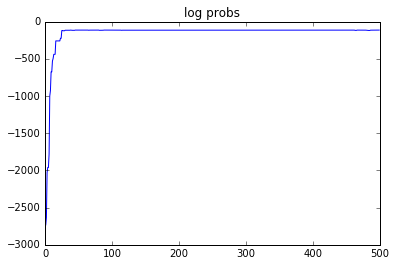

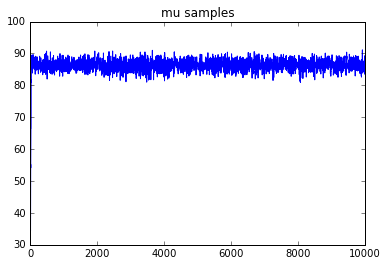

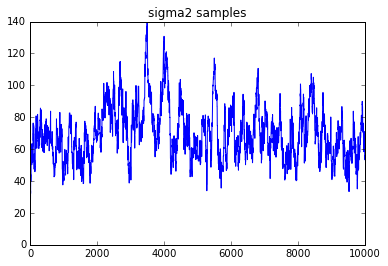

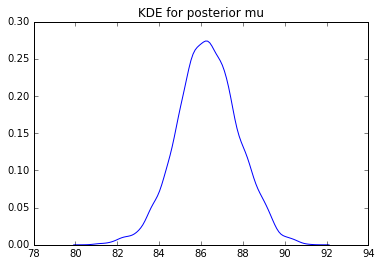

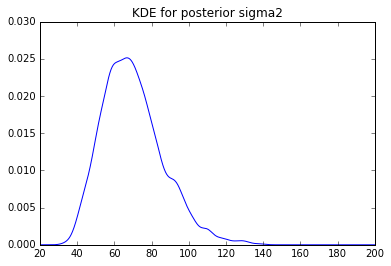

In [216]:
def example1():
    draws, lprobs, rate = metropolis(np.array([40, 10], dtype=float), 20., 10000)
    print "Acceptance Rate:", rate
    
    # plot the first 500 log probs
    plt.plot(lprobs[:500])
    plt.title('log probs')
    plt.show()
    # plot the mu samples
    plt.plot(draws[:,0])
    plt.title('mu samples')
    plt.show()
    # plot the sigma2 samples
    plt.plot(draws[:,1])
    plt.title('sigma2 samples')
    plt.show()
    # build and plot KDE for posterior mu
    mu_kernel = gaussian_kde(draws[50:,0])
    x_min = min(draws[50:,0]) - 1
    x_max = max(draws[50:,0]) + 1
    x = np.arange(x_min, x_max, step=0.1)
    plt.plot(x,mu_kernel(x))
    plt.title('KDE for posterior mu')
    plt.show()
    # build and plot KDE for posterior sigma2
    sig_kernel = gaussian_kde(draws[50:,1])
    x_min = 20
    x_max = 200
    x = np.arange(x_min, x_max, step=0.1)
    plt.plot(x,sig_kernel(x))
    plt.title('KDE for posterior sigma2')
    plt.show()
example1()

### Problem 1

Problem 1. Write a function that initializes a spin configuration for an n × n lattice. It should return an $n × n$ array, each entry of which is either 1 or −1, chosen randomly. Test this for the grid described above, and plot the spin configuration using matplotlib.pyplot.imshow. It should look fairly random, as in Figure 2.3.

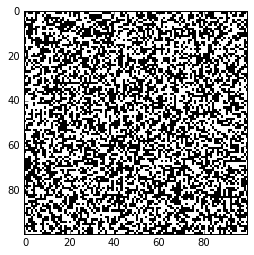

In [217]:
def spin_config(N=100):
    np.random.seed(2)
    return np.random.randint(2,size=(N,N))*2-1

myconfig = spin_config()
plt.imshow(myconfig,cmap='gray',interpolation='nearest')
plt.show()

### Problem 2

Problem 2. Write a function that computes the energy of a wrap-around
$n × n$ lattice with a given spin configuration, as described above. Make sure
that you do not double count site pair interactions

In [218]:
def get_energy(spinconfig,J=1):
    energy = 0
    N = np.shape(spinconfig)[0]
    for i in xrange(N):
        for j in xrange(N):
            energy += spinconfig[i,j]*spinconfig[(i+1)%N,j]
            energy += spinconfig[i,j]*spinconfig[i,(j+1)%N]
    return -J*energy
energy = get_energy(myconfig)
print energy

-116


### Problem 3

Problem 3. Write a function that proposes a new spin configuration given
the current spin configuration on an n × n lattice, as described above. This
function simply needs to return a pair of indices (i, j), chosen with probability
$\frac{1}{n^2}$ .

In [219]:
def new_spin_proposal(N=100):
    return np.random.randint(N),np.random.randint(N)
flipsite = new_spin_proposal()
print flipsite

(25, 40)


### Problem 4

Problem 4. Write a function that computes the energy of a proposed spin
configuration, given the current spin configuration, its energy, and the proposed
spin flip site indices.

In [220]:
def get_flip_energy(spinconfig,energy,flipsite,N=100):
    i,j = flipsite
    flipenergy = spinconfig[i,j]*(spinconfig[(i+1)%N,j] + spinconfig[(i-1),j] +spinconfig[i,(j+1)%N] + spinconfig[i,(j-1)])
    
    return energy+2*flipenergy   
flipenergy = get_flip_energy(myconfig,energy,flipsite,N=100)
print flipenergy

-112


### Problem 5

Problem 5. Write a function that accepts or rejects a proposed spin configuration,
given the current configuration. It should accept the current energy,
the proposed energy, and β, and should return a boolean.

In [221]:
def accept_flip(energy,flipenergy,beta):
    probability=1
    if flipenergy>energy: 
        probability = np.exp(beta*(energy-flipenergy))
    return np.random.rand()<=probability
accept_flip(energy,flipenergy,.2)

False

### Problem 6 

Problem 6. Write a function that initializes a spin configuration for an
$n×n$ lattice as done previously, and then performs the Metropolis algorithm,
choosing new spin configurations and accepting or rejecting them. It should
burn in first, and then iterate n samples times, keeping every 100th sample
(this is to prevent memory failure) and all of the above values for −βH(σ)
(keep the values even for the burn-in period). It should also accept β as an
argument, allowing us to effectively adjust the temperature for the model.

In [222]:
def metropolis2(n_samples,N=100,beta=1):
    accept_counter=0
    logprob = []
     
    config = spin_config(N)
    samples = [config.copy()]
    energy = get_energy(config)
    
    #burn-in
    for i in xrange(1000):
        flipsite = new_spin_proposal(N)
        proposal_energy = get_flip_energy(config,energy,flipsite,N)
        logprob.append(-beta*energy)
        if accept_flip(energy,proposal_energy,beta):
            config[flipsite] *=-1
            energy = proposal_energy
            
    for i in xrange(n_samples):
        flipsite = new_spin_proposal(N)
        proposal_energy = get_flip_energy(config,energy,flipsite,N)
        logprob.append(-beta*energy)
        if accept_flip(energy,proposal_energy,beta):
            accept_counter+=1
            config[flipsite] *=-1
            energy = proposal_energy
        if i%100==0: samples.append(config.copy())  
    return samples, logprob, accept_counter/float(n_samples)

### Problem 7

Problem 7. Test your Metropolis sampler on a 100×100 grid, with 200000
iterations, with n samples large enough so that you will keep 50 samples,
testing with β = 1 and then with β = 0.2. Plot the proportional log probabilities,
and also plot a late sample from each test using matplotlib.pyplot.imshow.
How does the ferromagnetic material behave differently with differing temperatures?
Recall that β is an inverse function of temperature. You should
see more structure with lower temperature, as illustrated in Figures 2.4b and
2.4d.

0.13679


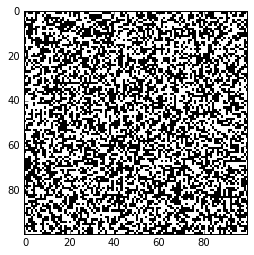

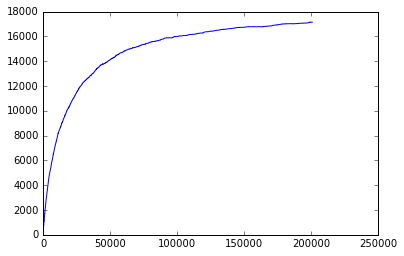

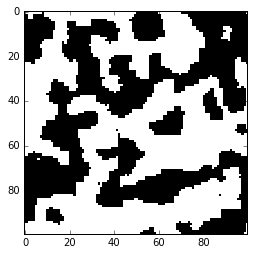

In [223]:
def prob7a():    
    ss,ll,pp = metropolis2(200000)
    print pp
    plt.imshow(ss[0],cmap='gray',interpolation='nearest')
    plt.show()
    plt.plot(ll)
    plt.show()
    plt.imshow(ss[-1],cmap='gray',interpolation='nearest')
    plt.show()
prob7a()

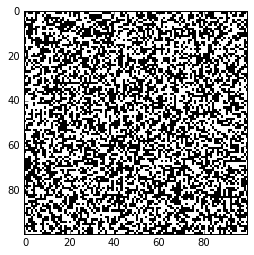

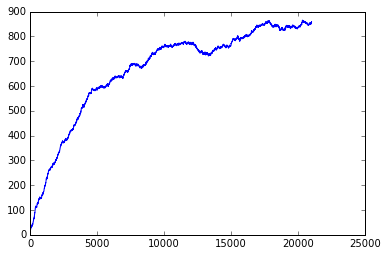

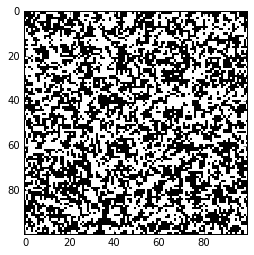

In [225]:
def prob7b():    
    ss,ll,pp = metropolis2(20000,beta=.2)
    plt.imshow(ss[0],cmap='gray',interpolation='nearest')
    plt.show()
    plt.plot(ll)
    plt.show()
    plt.imshow(ss[-1],cmap='gray',interpolation='nearest')
    plt.show()
prob7b()